# Import Modules

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf
import graphviz

from datetime import datetime
from keras.layers import Dense
from keras.models import Sequential
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import chi2
from sklearn.feature_selection import r_regression, SelectKBest
from sklearn.feature_selection import r_regression, SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils._testing import ignore_warnings
from tensorflow import keras
from keras.callbacks import TensorBoard
from tabulate import tabulate
from xgboost import XGBClassifier

%matplotlib inline


In [4]:
pd.set_option('display.show_dimensions', True)
pd.set_option('display.max_columns', 200)


# Load Data

In [5]:
def parse_arrival_time(arrival_time, doj, year='2019'):
    """This function takes in the arrival_time variable as a string from the dataset as HH:MM time, and the date of journey and returns a datetime object.
    arrival_time: string
    doj: datetime object
    """

    arr_time = arrival_time.split(' ')

    if len(arr_time) > 1:
        time = arr_time[0]
        day = arr_time[1]
        mon = arr_time[2]

    else:
        time = arrival_time
        day = doj.strftime('%d')
        mon = doj.strftime('%b')
        year = doj.strftime('%Y')

    dt_string = '{}-{}-{} {}'.format(year, mon, day, time)
    dt_object = datetime.strptime(dt_string, '%Y-%b-%d %H:%M')

    return dt_object


In [6]:
def parse_departure_time(doj, dep_time):
    day = doj.strftime('%d')
    mon = doj.strftime('%b')
    year = doj.strftime('%Y')

    dt_string = '{}-{}-{} {}'.format(year, mon, day, dep_time)
    dt_object = datetime.strptime(dt_string, '%Y-%b-%d %H:%M')

    return dt_object


In [7]:
# load csv
df = pd.read_csv('../Datasets/airline ticket prices.csv', parse_dates=[
                 'Date_of_Journey'], dayfirst=True)

df['DT_Arrival_Time'] = df.apply(lambda df: parse_arrival_time(
    df['Arrival_Time'], df['Date_of_Journey']), axis=1)

df['DT_Departure_Time'] = df.apply(lambda df: parse_departure_time(
    df['Date_of_Journey'], df['Dep_Time']), axis=1)

df['DT_Duration'] = df['DT_Arrival_Time'] - df['DT_Departure_Time']

# remove the original departure/arrival date and time columns
df.drop(['Date_of_Journey', 'Dep_Time', 'Arrival_Time',
        'Duration'], axis=1, inplace=True)

# remove negative duration flights
df = df[df.DT_Duration > pd.Timedelta(days=0)].reset_index()
df.drop(labels='index', axis=1, inplace=True)

In [8]:
df.head()

Airline    Source Destination                  Route Total_Stops  \
0    Air India   Kolkata    Banglore  CCU ? IXR ? BBI ? BLR     2 stops   
1  Jet Airways     Delhi      Cochin  DEL ? LKO ? BOM ? COK     2 stops   
2       IndiGo   Kolkata    Banglore        CCU ? NAG ? BLR      1 stop   
3       IndiGo  Banglore   New Delhi        BLR ? NAG ? DEL      1 stop   
4     SpiceJet   Kolkata    Banglore              CCU ? BLR    non-stop   

  Additional_Info  Price     DT_Arrival_Time   DT_Departure_Time  \
0         No info   7662 2019-05-01 13:15:00 2019-05-01 05:50:00   
1         No info  13882 2019-06-10 04:25:00 2019-06-09 09:25:00   
2         No info   6218 2019-05-12 23:30:00 2019-05-12 18:05:00   
3         No info  13302 2019-03-01 21:35:00 2019-03-01 16:50:00   
4         No info   3873 2019-06-24 11:25:00 2019-06-24 09:00:00   

      DT_Duration  
0 0 days 07:25:00  
1 0 days 19:00:00  
2 0 days 05:25:00  
3 0 days 04:45:00  
4 0 days 02:25:00  

[5 rows x 10 columns]

In [9]:
df.isna().sum()

Airline              0
Source               0
Destination          0
Route                1
Total_Stops          1
Additional_Info      0
Price                0
DT_Arrival_Time      0
DT_Departure_Time    0
DT_Duration          0
Length: 10, dtype: int64

In [10]:
df.dropna(how='any', inplace=True)
df.reset_index()
df.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10590 entries, 0 to 10590
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   Airline            10590 non-null  object         
 1   Source             10590 non-null  object         
 2   Destination        10590 non-null  object         
 3   Route              10590 non-null  object         
 4   Total_Stops        10590 non-null  object         
 5   Additional_Info    10590 non-null  object         
 6   Price              10590 non-null  int64          
 7   DT_Arrival_Time    10590 non-null  datetime64[ns] 
 8   DT_Departure_Time  10590 non-null  datetime64[ns] 
 9   DT_Duration        10590 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), object(6), timedelta64[ns](1)
memory usage: 910.1+ KB


# Categorical Encoding

In [11]:
# create a dataframe copy just for feature selection
df_fs = df.copy(deep=True)

# encode the categorical data
cat_cols = [col for col in df_fs.columns if df_fs[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df_fs[cat_cols] = oe.fit_transform(df_fs[cat_cols])

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']


In [12]:
# convert datetime columns to float
df_fs['DT_Arrival_Time'] = df_fs['DT_Arrival_Time'].astype(np.int64)
df_fs['DT_Departure_Time'] = df_fs['DT_Departure_Time'].astype(np.int64)
df_fs['DT_Duration'] = df_fs['DT_Duration'].astype(np.int64)

In [13]:
df_fs.shape

(10590, 10)

# Feature Selection

## Drop Useless Features

In [14]:
x = df_fs.drop('Price', axis=1)
y = df_fs['Price']

In [15]:
# create this empty set to collect only the selected features later
features = set()

## Lasso Model

In [16]:
reg = LassoCV()
reg.fit(x, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(x, y))
coef = pd.Series(reg.coef_, index=x.columns)

Best alpha using built-in LassoCV: 1931256099500277.750000
Best score using built-in LassoCV: 0.204162


In [17]:
print("Lasso picked " + str(sum(coef != 0)) +
      " variables and eliminated the other " + str(sum(coef == 0)) + " variables.")

Lasso picked 3 variables and eliminated the other 6 variables.


Text(0.5, 1.0, 'Feature importance using Lasso Model')

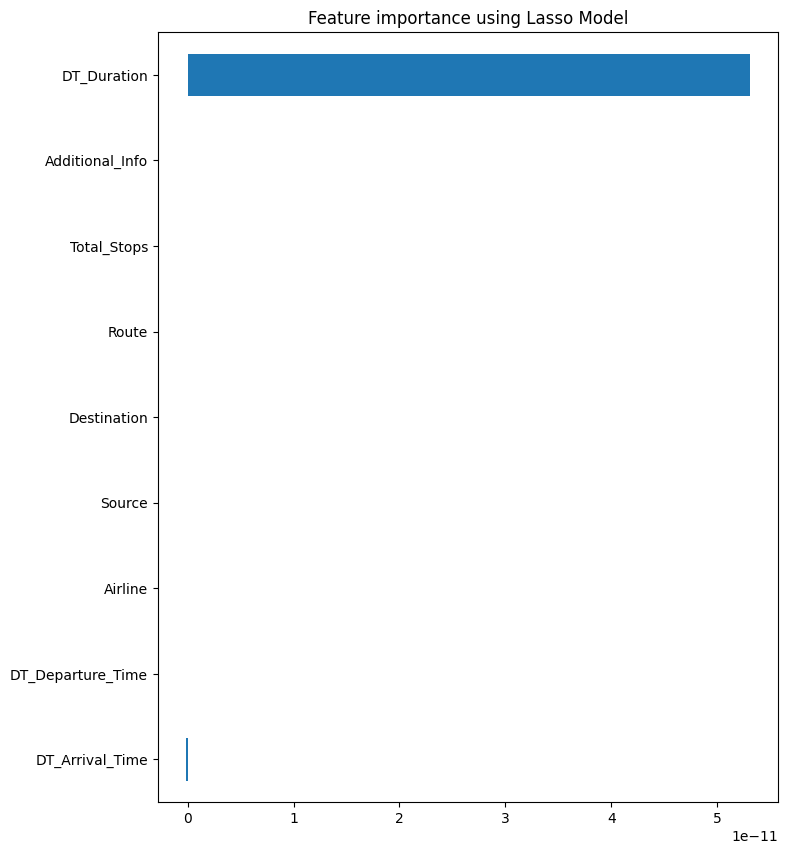

In [18]:
imp_coef = coef.sort_values()
mpl.rcParams['figure.figsize'] = (8, 10)
imp_coef.plot(kind="barh")
plt.title("Feature importance using Lasso Model")


In [19]:
for item in imp_coef[imp_coef != 0].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding DT_Arrival_Time.
Adding DT_Departure_Time.
Adding DT_Duration.


## Chi-square

In [20]:
# x contains negative values that cannot be used for chi2
# let's normalize x
scalar = MinMaxScaler()
x_chi = scalar.fit_transform(x)
chi_scores = chi2(x_chi, y)

<AxesSubplot:>

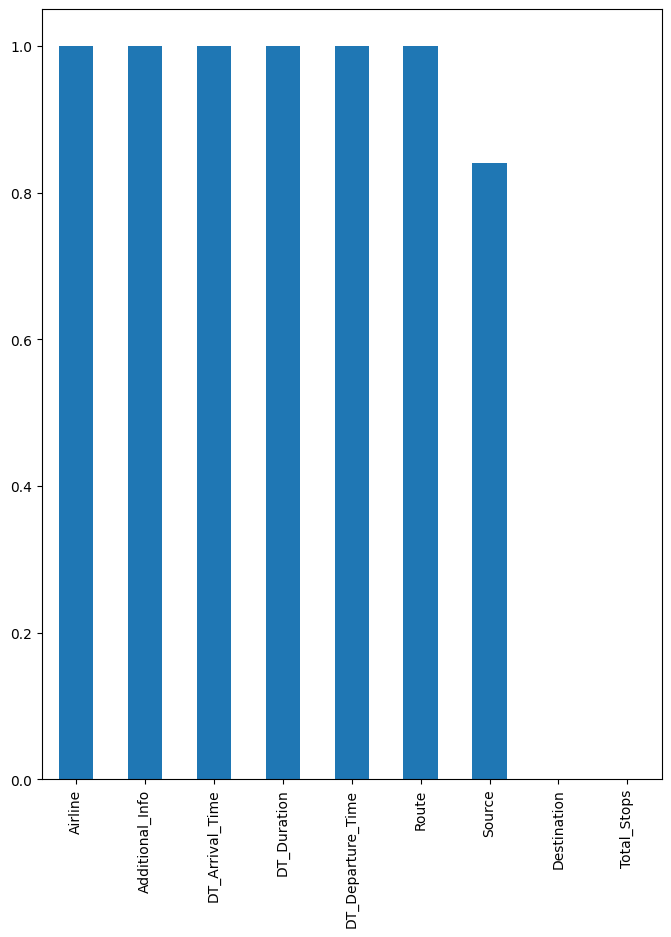

In [21]:
# extract and plot the p-values
p_values = pd.Series(chi_scores[1], index=x.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

In [22]:
for item in p_values[p_values > 0.001].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding Airline.
Adding Additional_Info.
Adding DT_Arrival_Time.
Adding DT_Duration.
Adding DT_Departure_Time.
Adding Route.
Adding Source.


## ANOVA f-value

<AxesSubplot:>

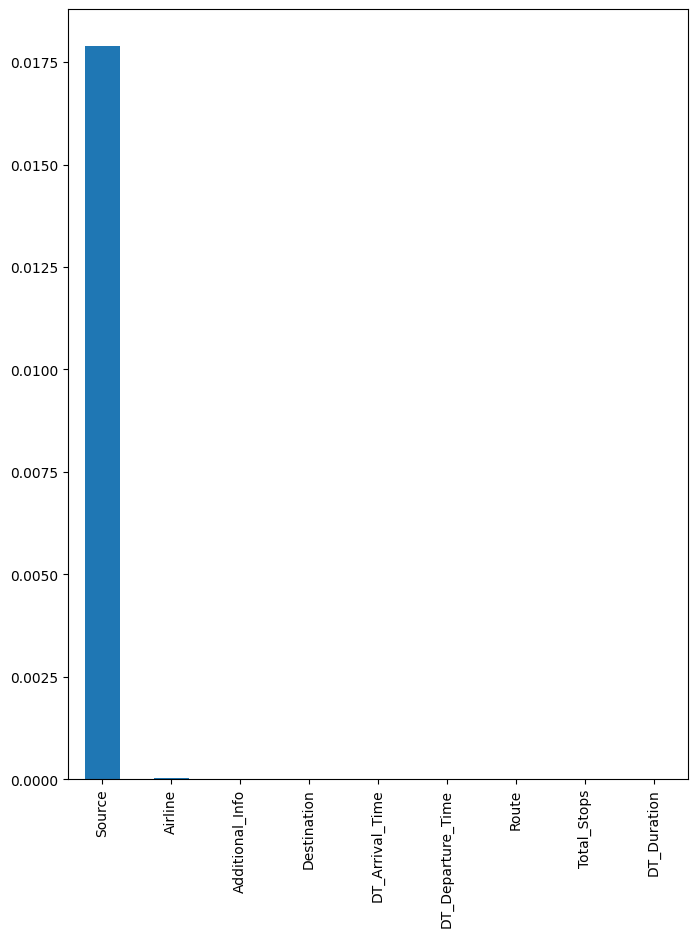

In [23]:
f_scores = f_regression(x, y)
# extract and plot the p-values
p_values = pd.Series(f_scores[1], index=x.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

In [24]:
for item in p_values[p_values > 0.0001].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding Source.


## Selected Features

In [25]:
print(f'These are the selected features: {features}.')

These are the selected features: {'Airline', 'Additional_Info', 'DT_Arrival_Time', 'DT_Duration', 'DT_Departure_Time', 'Source', 'Route'}.


# Machine Learning

## Principal Component Analysis
It seems that feature selection generally select all features, and as a result we will just proceed with multilinear regression models using PCA.

In [26]:
df_fs.head()

Airline  Source  Destination  Route  Total_Stops  Additional_Info  Price  \
0      1.0     3.0          0.0   84.0          1.0              8.0   7662   
1      4.0     2.0          1.0  118.0          1.0              8.0  13882   
2      3.0     3.0          0.0   91.0          0.0              8.0   6218   
3      3.0     0.0          5.0   29.0          0.0              8.0  13302   
4      8.0     3.0          0.0   64.0          4.0              8.0   3873   

       DT_Arrival_Time    DT_Departure_Time     DT_Duration  
0  1556716500000000000  1556689800000000000  26700000000000  
1  1560140700000000000  1560072300000000000  68400000000000  
2  1557703800000000000  1557684300000000000  19500000000000  
3  1551476100000000000  1551459000000000000  17100000000000  
4  1561375500000000000  1561366800000000000   8700000000000  

[5 rows x 10 columns]

In [27]:
df_fs['Price'].isnull().value_counts()

False    10590
Name: Price, Length: 1, dtype: int64

In [28]:
# define x and y using df_fs since it's encoded and contains float numbers only at this point
x = df_fs.drop('Price', axis=1)

pca = PCA(n_components=2)
pca_tickets = pca.fit_transform(x)

df_pca = pd.DataFrame(data=pca_tickets, columns=['PCA 1', 'PCA 2'])
df_pca.index = df_fs.index  # align the indices 
df_pca['Price'] = df_fs['Price']

print(
    f'Explained variation per principal component: {pca.explained_variance_ratio_}')

Explained variation per principal component: [9.99899396e-01 1.00604106e-04]


In [29]:
df_pca.head()

PCA 1         PCA 2  Price
0  5.626580e+14 -1.611285e+13   7662
1 -4.250386e+15  3.676136e+13  13882
2 -8.386894e+14 -2.440625e+13   6218
3  7.966910e+15 -3.064308e+13  13302
4 -6.038899e+15 -3.568617e+13   3873

[5 rows x 3 columns]

## Multilinear Regression

In [30]:
def mlinear_regression_model(x, y, x_label, y_label):
    """"This function takes in x and y in a numpy array form, and returns the
    linear regression equation, R2, MSE, and RMSE. It also graphs the whole
    thing.

    This function only works with either 2 x variables or 3. In the case of 3 x
    variables there will be no graph.
    """
    model = linear_model.LinearRegression().fit(x, y)

    # Get the intercept (a_0) and coefficients (a_1 / a_2)
    a_0 = model.intercept_
    a_1 = model.coef_[0]
    a_2 = model.coef_[1]

    if len(x_label) == 3:
        a_3 = model.coef_[2]
    else:
        a_3 = None

    # Scoring the prediction accuracy
    y_pred = model.predict(x)

    # metrics
    mae = metrics.mean_absolute_error(y, y_pred)
    mse = metrics.mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mape = metrics.mean_absolute_percentage_error(y, y_pred)
    r2_score = metrics.r2_score(y, y_pred)

    if len(x_label) == 2:
        print(f'The linear regression equation is y = {a_0} + {a_1}*x_1 + {a_2}*x_2')
    else:
        print(f'The linear regression equation is y = {a_0} + {a_1}*x_1 + {a_2}*x_2 + {a_3}*x_3')
    print(f'R2 is {r2_score} ')
    print(f'The mean squared error (MSE) is {mse}')
    print(f'The root mean squared error (RMSE) is {rmse}')
    print(f'The mean absolute error (MAE) is {mae}')
    print(f'The mean absolute percentaage error (MAPE) is {mape}')
    print()

    if len(x_label) == 2:
        # Graph
        fig = plt.figure(figsize=(8, 6), dpi=100).add_subplot(projection='3d')
        # mpl.rcParams['legend.fontsize'] = 12

        # ax = fig.gca()

        fig.view_init(30, 30)

        fig.scatter(x[:, 0], x[:, 1], y)
        fig.plot(x[:, 0], x[:, 1], y_pred, c='r')
        fig.set_xlabel(x_label[0])
        fig.set_ylabel(x_label[1])
        fig.set_zlabel(y_label[0])
        # ax.legend()
        plt.show()
    else:
        return


The linear regression equation is y = 9067.380736536712 + 1.3679902335301143e-13*x_1 + 4.4462108937869156e-11*x_2
R2 is 0.20429843997790853 
The mean squared error (MSE) is 16604971.292730609
The root mean squared error (RMSE) is 4074.9197897296835
The mean absolute error (MAE) is 2998.463683109471
The mean absolute percentaage error (MAPE) is 0.41924714930431184



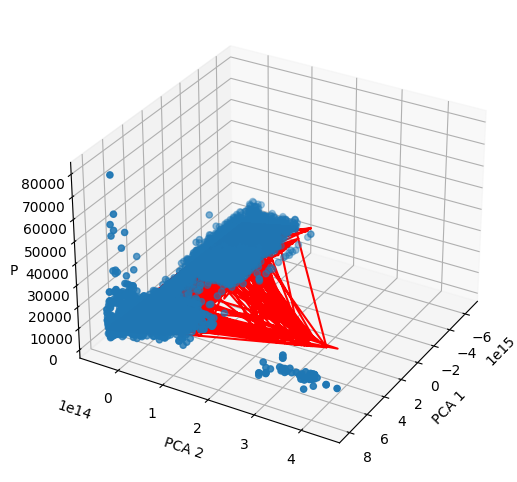

In [31]:
mlr = mlinear_regression_model(
    df_pca[['PCA 1', 'PCA 2']].values, df_pca['Price'].values, ['PCA 1', 'PCA 2'], 'Price')

## Polynomial Regression

In [32]:
def polynomial_regression_model(x, y, x_label, y_label, deg):
    """"This function takes in x and y in numpy array forms, and returns the
    polynomial regression equation, R2, MSE, and RMSE. This function works with 
    just one x variable.
    """
    # Create the polynomial regression model
    poly_reg = PolynomialFeatures(degree=deg)
    x_poly = poly_reg.fit_transform(x)

    # Create the linear regression model and fit x and y
    lin = linear_model.LinearRegression()
    lin.fit(x, y)

    y_pred = lin.predict(x)

    # Create the linear regression model and fit x_poly and y
    lin2 = linear_model.LinearRegression()
    lin2.fit(x_poly, y)

    y_pred_poly = lin2.predict(poly_reg.fit_transform(x))

    # metrics
    mae = metrics.mean_absolute_error(y, y_pred_poly)
    mse = metrics.mean_squared_error(y, y_pred_poly)
    rmse = np.sqrt(mse)
    mape = metrics.mean_absolute_percentage_error(y, y_pred_poly)
    r2_score = metrics.r2_score(y, y_pred_poly)

    # print(f'The linear regression equation is y = {a_0} + {a_1}*x_1 + {a_2}*x_2 + {a_3}*x_3')
    deg_text = '2nd' if deg == 2 else '3rd' if deg == 3 else f'{deg}th'
    print(
        f'Metrics and plots for Linear and Polynomial models of the {deg_text} degree:')
    print(f'R2 is {r2_score}')
    print(f'The mean squared error (MSE) is {mse}')
    print(f'The root mean squared error (RMSE) is {rmse}')
    print(f'The mean absolute error (MAE) is {mae}')
    print(f'The mean absolute percentaage error (MAPE) is {mape}')

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # plot 2 graphs
    # Visualising the Linear Regression results
    axes[0].scatter(x, y, color='blue')
    axes[0].plot(x, y_pred, color='red')
    axes[0].set_title('Linear Regression')

    # Visualising the Polynomial Regression results
    axes[1].scatter(x, y, color='blue')
    axes[1].plot(x, y_pred_poly, color='red')
    axes[1].set_title('Polynomial Regression')

    # Set the labels
    for ax in axes.flat:
        ax.set(xlabel=x_label, ylabel=y_label)

    plt.show()

Metrics and plots for Linear and Polynomial models of the 2nd degree:
R2 is 0.06340940492972891
The mean squared error (MSE) is 19545091.68456519
The root mean squared error (RMSE) is 4420.98311290206
The mean absolute error (MAE) is 3573.4434468929867
The mean absolute percentaage error (MAPE) is 0.5343831022600009


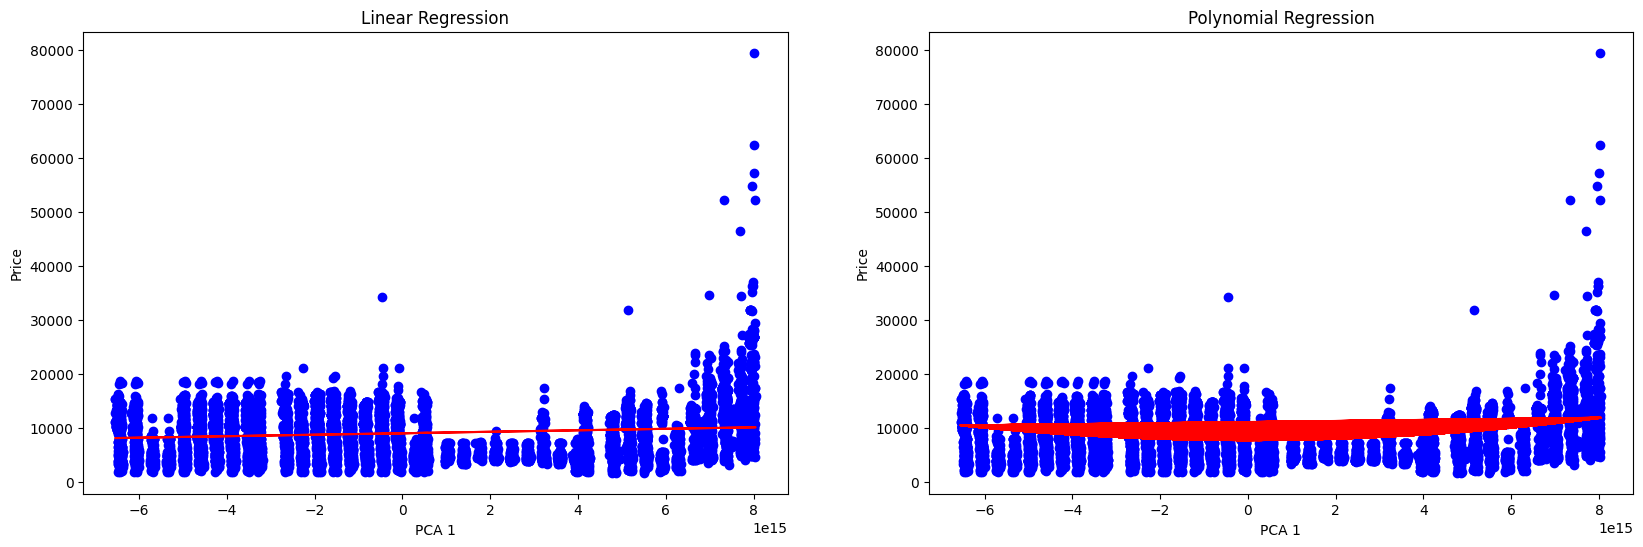

In [33]:
prm1 = polynomial_regression_model(
    df_pca['PCA 1'].values.reshape(-1, 1), df_pca['Price'].values, 'PCA 1', 'Price', 2)

Metrics and plots for Linear and Polynomial models of the 3rd degree:
R2 is 0.07519792812549309
The mean squared error (MSE) is 19299084.76553399
The root mean squared error (RMSE) is 4393.07236060755
The mean absolute error (MAE) is 3578.5995396831563
The mean absolute percentaage error (MAPE) is 0.5344553925846827


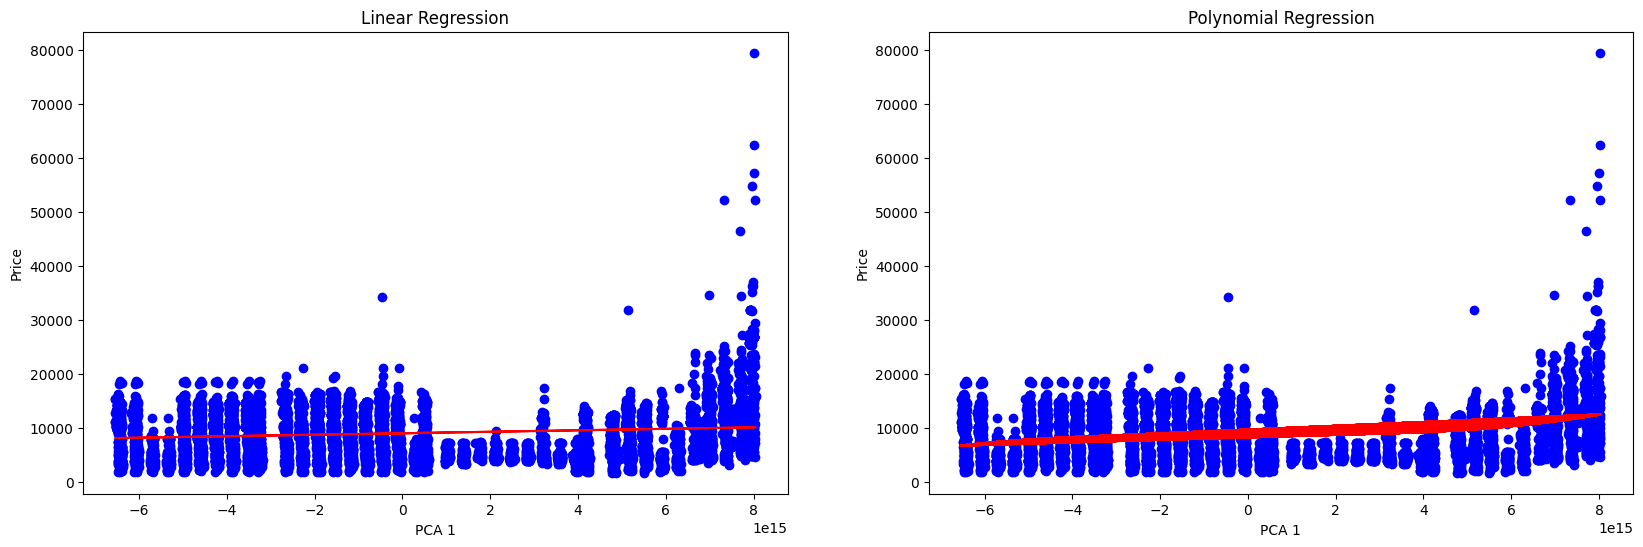

In [34]:
prm2 = polynomial_regression_model(
    df_pca['PCA 1'].values.reshape(-1, 1), df_pca['Price'].values, 'PCA 1', 'Price', 3)

Metrics and plots for Linear and Polynomial models of the 4th degree:
R2 is 0.10421698925472189
The mean squared error (MSE) is 18693505.10953902
The root mean squared error (RMSE) is 4323.598629560684
The mean absolute error (MAE) is 3515.3723600333715
The mean absolute percentaage error (MAPE) is 0.5248968639640577


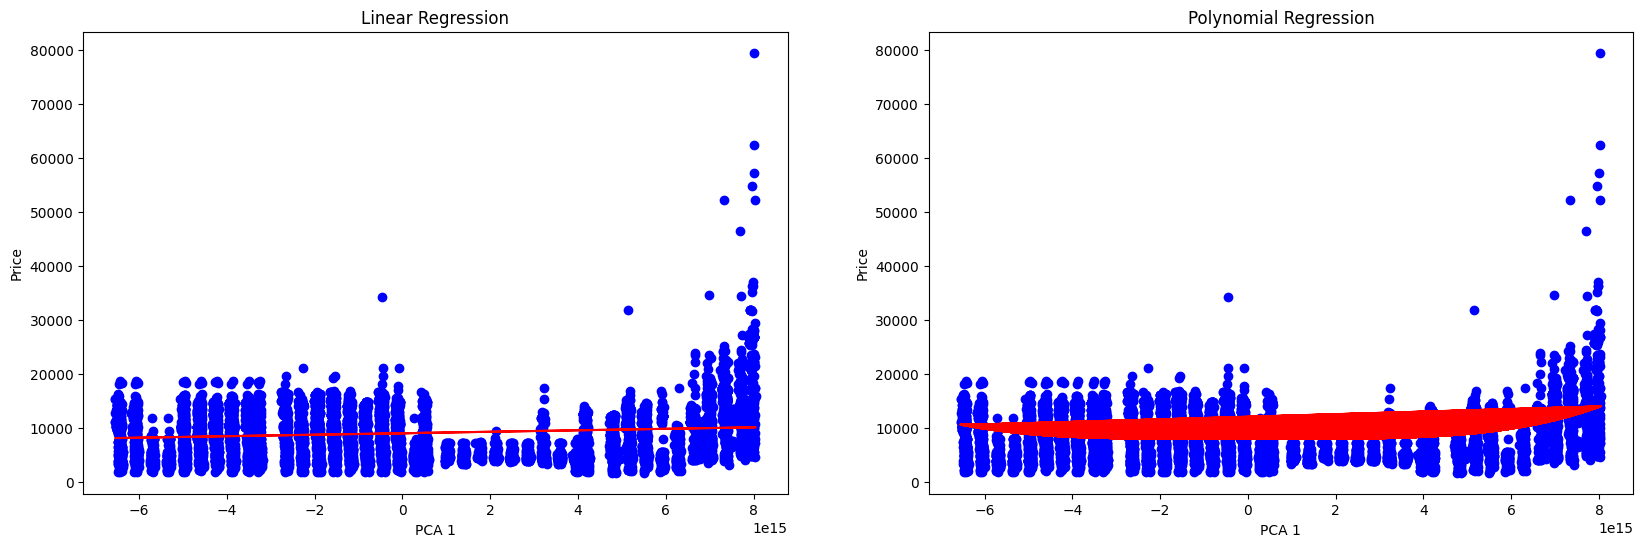

In [35]:
prm3 = polynomial_regression_model(
    df_pca['PCA 1'].values.reshape(-1, 1), df_pca['Price'].values, 'PCA 1', 'Price', 4)

Metrics and plots for Linear and Polynomial models of the 5th degree:
R2 is 0.11401707257265892
The mean squared error (MSE) is 18488993.631446414
The root mean squared error (RMSE) is 4299.882978808425
The mean absolute error (MAE) is 3513.513974998811
The mean absolute percentaage error (MAPE) is 0.5236849884940418


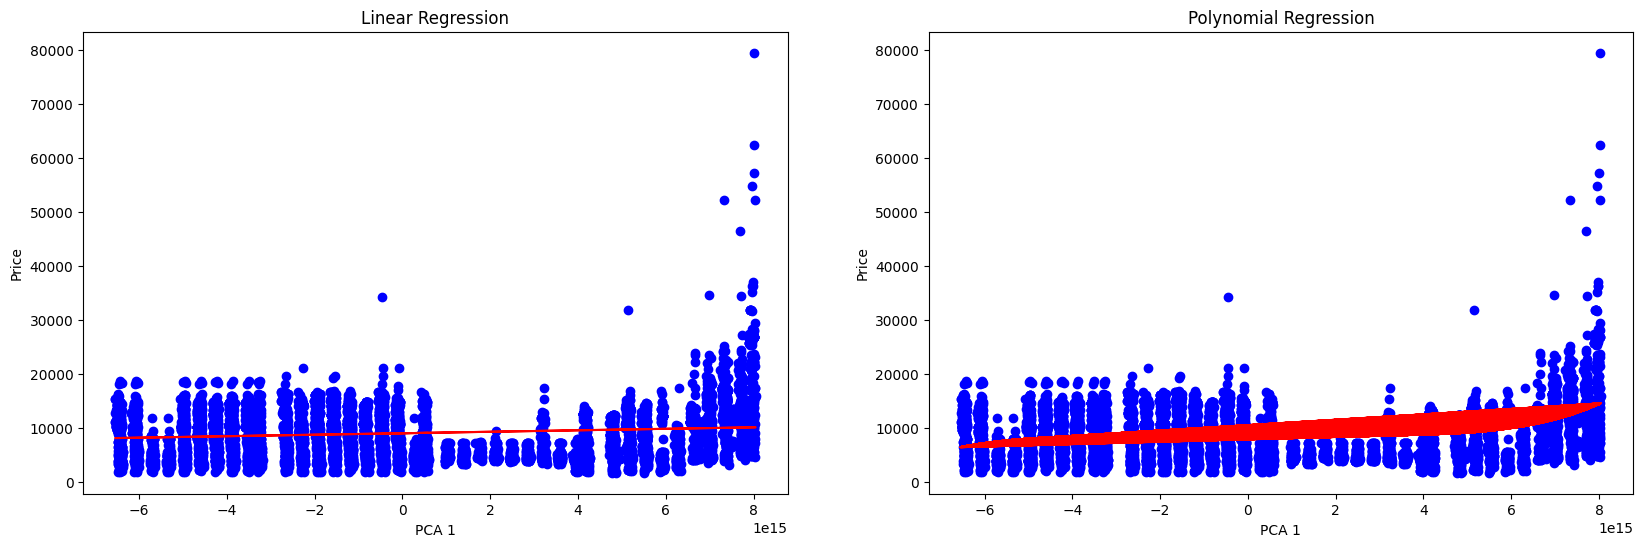

In [36]:
prm3 = polynomial_regression_model(
    df_pca['PCA 1'].values.reshape(-1, 1), df_pca['Price'].values, 'PCA 1', 'Price', 5)

## Decision Trees

### Decision Tree Regression

In [37]:
x = df_fs.drop('Price', axis=1)
y = df_fs['Price']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=0)

In [38]:
dtregressor = DecisionTreeRegressor()
dtregressor.fit(x_train, y_train)


DecisionTreeRegressor()

In [39]:
columns = x.columns.tolist()
print(tree.export_text(dtregressor, feature_names=columns, show_weights=True))

|--- DT_Duration <= 19650000715776.00
|   |--- DT_Departure_Time <= 1551903006964842496.00
|   |   |--- Additional_Info <= 4.50
|   |   |   |--- value: [57209.00]
|   |   |--- Additional_Info >  4.50
|   |   |   |--- Route <= 11.50
|   |   |   |   |--- DT_Departure_Time <= 1551536113678548992.00
|   |   |   |   |   |--- DT_Departure_Time <= 1551438188424200192.00
|   |   |   |   |   |   |--- DT_Duration <= 19200000131072.00
|   |   |   |   |   |   |   |--- value: [22270.00]
|   |   |   |   |   |   |--- DT_Duration >  19200000131072.00
|   |   |   |   |   |   |   |--- value: [26890.00]
|   |   |   |   |   |--- DT_Departure_Time >  1551438188424200192.00
|   |   |   |   |   |   |--- value: [36235.00]
|   |   |   |   |--- DT_Departure_Time >  1551536113678548992.00
|   |   |   |   |   |--- DT_Departure_Time <= 1551737118148001792.00
|   |   |   |   |   |   |--- value: [11873.00]
|   |   |   |   |   |--- DT_Departure_Time >  1551737118148001792.00
|   |   |   |   |   |   |--- value: [19225

#### Performance Evaluation

In [40]:
# predict new y's
y_pred = dtregressor.predict(x_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
r2_score = metrics.r2_score(y_test, y_pred)

print('MAE\t\t=', mae)
print('MSE\t\t=', mse)
print('RMSE\t\t=', rmse)
print('MAPE\t\t=', mape)  # value is under 10% which is very good
print('R2 Score\t=', r2_score)


MAE		= 795.8958136606861
MSE		= 4515283.624173749
RMSE		= 2124.9196747580245
MAPE		= 0.08881038319994415
R2 Score	= 0.7884453690709302


#### Decision Tree Visualization

In [41]:
tree_fig = tree.export_graphviz(
    dtregressor, feature_names=columns, filled=True)
graph = graphviz.Source(tree_fig, format='png')
graph


#### Feature Importance

Text(0.5, 1.0, 'Feature Impotance')

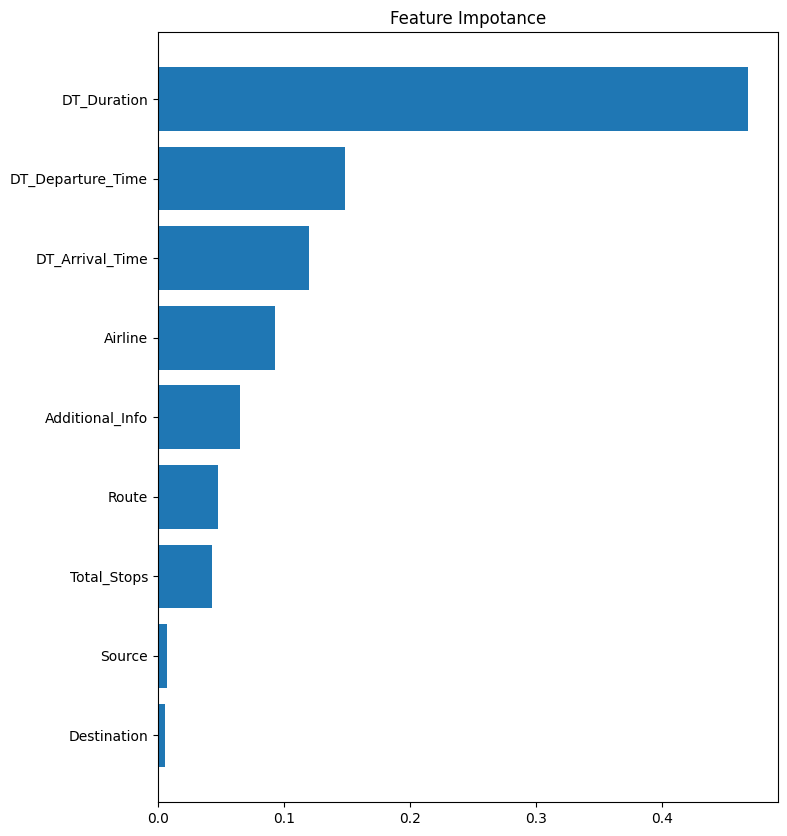

In [42]:
importance = dtregressor.feature_importances_

indicies = np.argsort(importance)

plt.barh(range(len(indicies)), importance[indicies])
plt.yticks(range(len(indicies)), [columns[i] for i in indicies])
plt.title('Feature Impotance')


### Random Forest Regression

In [43]:
x = df_fs.drop('Price', axis=1)
y = df_fs['Price']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=0)

In [44]:
rfregressor = RandomForestRegressor()
rfregressor.fit(x_train, y_train)


RandomForestRegressor()

#### Performance Evaluation

In [45]:
# predict new y's
y_pred = rfregressor.predict(x_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
r2_score = metrics.r2_score(y_test, y_pred)

print('MAE\t\t=', mae)
print('MSE\t\t=', mse)
print('RMSE\t\t=', rmse)
print('MAPE\t\t=', mape)  # value is under 10% which is very good
print('R2 Score\t=', r2_score)


MAE		= 713.8424142422471
MSE		= 2221897.711355879
RMSE		= 1490.6031367724538
MAPE		= 0.08277486382254176
R2 Score	= 0.8958974032613394


#### Random Forest Visualization

In [46]:
columns = x_train.columns.tolist()
now = int(datetime.now().strftime('%Y%m%d'))
filename = f'RandomForestRegressor_{now}'

for tree_in_forest in rfregressor.estimators_:
    tree_fig = tree.export_graphviz(
        tree_in_forest, feature_names=columns, filled=True)
    graph = graphviz.Source(tree_fig, format='pdf')
    graph

graph.render(filename, format='pdf', view=True)


'RandomForestRegressor_20221121.pdf'

#### Feature Importance

Text(0.5, 1.0, 'Feature Impotance')

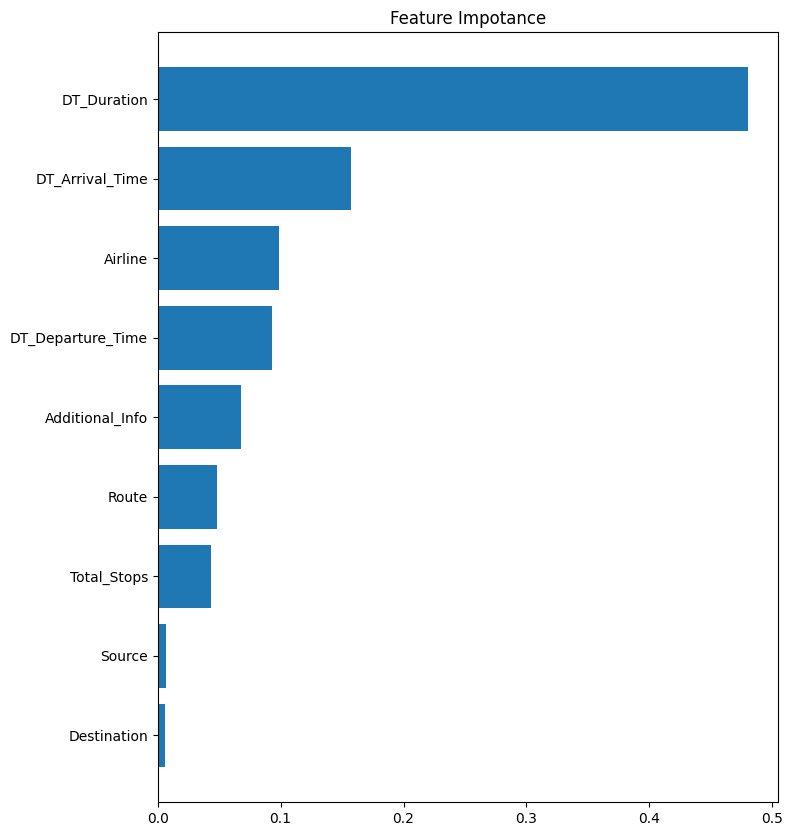

In [47]:
importance = rfregressor.feature_importances_

indicies = np.argsort(importance)

plt.barh(range(len(indicies)), importance[indicies])
plt.yticks(range(len(indicies)), [columns[i] for i in indicies])
plt.title('Feature Impotance')


# Deep Learning

In [54]:
%load_ext tensorboard

# create folders
now = datetime.now().strftime('%Y%m%d%H%M')
log_folder = f'Tensorboard Logs/Regression - Airline Ticket Prices {now}'

# callbacks for TensorBoard
callbacks = TensorBoard(log_dir=log_folder, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
# x and y
x_dl = df_fs.drop('Price', axis=1).values
y_dl = df_fs['Price'].values

In [56]:
# need to scale down x values because otherwise the model returns nan mse
sc = StandardScaler()
x_scaled = sc.fit_transform(x_dl)

In [57]:
# clear previous sessions
keras.backend.clear_session()

# create keras model
model = keras.models.Sequential([
    keras.layers.Dense(15, activation='relu', input_dim=x_dl.shape[1]),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1)  # in case of multiple classification use more perceptrons and softmax
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                150       
                                                                 
 dense_1 (Dense)             (None, 8)                 128       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [59]:
# use MAE instead of MSE for smaller values
model.compile(optimizer='adam', loss='MeanAbsoluteError',
              metrics=['MeanAbsoluteError'])

model.fit(x=x_scaled, y=y_dl, validation_split=0.2,
          epochs=200, callbacks=callbacks)

Epoch 1/200
265/265 [==============================] - 1s 2ms/step - loss: 9043.2188 - mean_absolute_error: 9043.2188 - val_loss: 9016.1807 - val_mean_absolute_error: 9016.1807
Epoch 2/200
265/265 [==============================] - 0s 2ms/step - loss: 8471.9746 - mean_absolute_error: 8471.9746 - val_loss: 7466.0449 - val_mean_absolute_error: 7466.0449
Epoch 3/200
265/265 [==============================] - 0s 1ms/step - loss: 5034.2007 - mean_absolute_error: 5034.2007 - val_loss: 3013.5583 - val_mean_absolute_error: 3013.5583
Epoch 4/200
265/265 [==============================] - 0s 1ms/step - loss: 2780.6416 - mean_absolute_error: 2780.6416 - val_loss: 2702.2678 - val_mean_absolute_error: 2702.2678
Epoch 5/200
265/265 [==============================] - 0s 1ms/step - loss: 2651.7278 - mean_absolute_error: 2651.7278 - val_loss: 2643.7837 - val_mean_absolute_error: 2643.7837
Epoch 6/200
265/265 [==============================] - 0s 1ms/step - loss: 2603.6741 - mean_absolute_error: 2603.67